# Market Basket Analysis with Spark on IMDB dataset


## Downloading Data

In [ ]:
from google.colab import files

In [ ]:
!pip install -q kaggle

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-14 06:30:31           7550  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4591  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1546  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-06-09 15:58:24           2223  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [ ]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:14<00:00, 123MB/s]
100% 1.44G/1.44G [00:14<00:00, 104MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from zipfile import ZipFile
with ZipFile("imdb-dataset.zip", 'r') as myzip:
    myzip.extractall(".")

In [ ]:
name_basics_path = '/content/name.basics.tsv/name.basics.tsv'
title_basics_path = '/content/title.basics.tsv/title.basics.tsv'
title_principals_path = '/content/title.principals.tsv/title.principals.tsv'
title_ratings_path = '/content/title.ratings.tsv/title.ratings.tsv'

## Preprocessing

In [ ]:
!pip install pyspark
import pyspark
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
sc = pyspark.SparkContext('local[*]')

     |████████████████████████████████| 212.4MB 60kB/s 
     |████████████████████████████████| 204kB 12.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=73ed8961f445987a5f8d44858e11695b566f3e33976208f52b03431fcc28957b
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

SPARK DATAFRAME CREATION


In [ ]:
name_basics_s = spark.read.csv(name_basics_path,sep='\t',header=True)


In [ ]:
title_basics_s = spark.read.csv(title_basics_path, header=True,sep='\t')

In [ ]:
title_principals_s = spark.read.csv(title_principals_path, header=True,sep='\t')

In [ ]:
title_ratings_s = spark.read.csv(title_ratings_path, header=True,sep='\t')

In [ ]:
type(name_basics_s)

pyspark.sql.dataframe.DataFrame

In [ ]:
title_basics_s.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
name_basics_s.createOrReplaceTempView("name_basics_s")
title_basics_s.createOrReplaceTempView("title_basics_s")
title_principals_s.createOrReplaceTempView("title_principals_s")
title_ratings_s.createOrReplaceTempView("title_ratings_s")

EXPLORING DATA

In [ ]:
name_basics_s.show(n = 5,)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
title_basics_s.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [ ]:
title_principals_s.show(n = 5)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



In [ ]:
title_ratings_s.show(n = 5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1550|
|tt0000002|          6.1|     186|
|tt0000003|          6.5|    1207|
|tt0000004|          6.2|     113|
|tt0000005|          6.1|    1934|
+---------+-------------+--------+
only showing top 5 rows



### Films with highest rating score and consistent number of voters
Filtered only movies (not series or shorts)

In [ ]:
query = """SELECT originalTitle,numVotes AS votes, averageRating as stars 
           FROM title_ratings_s 
           INNER JOIN title_basics_s as t
           ON title_ratings_s.tconst = t.tconst
           WHERE titleType = 'movie'
           AND numVotes > 200
           ORDER BY stars DESC"""

res = spark.sql(query)
res.show(truncate = False)

+-----------------------------------------------------------------------+-----+-----+
|originalTitle                                                          |votes|stars|
+-----------------------------------------------------------------------+-----+-----+
|Gini Helida Kathe                                                      |425  |9.8  |
|Randhawa                                                               |816  |9.8  |
|Square One                                                             |498  |9.8  |
|Hare Krishna! The Mantra, the Movement and the Swami Who Started It All|1200 |9.7  |
|Android Kunjappan Version 5.25                                         |1175 |9.6  |
|Fan                                                                    |1010 |9.6  |
|Mama's Heart. Gongadze                                                 |502  |9.6  |
|Retrocausality                                                         |1420 |9.5  |
|Yeh Suhaagraat Impossible                            

### Films produced every year

In [ ]:
query2 = """SELECT COUNT(tconst) as films, startYear as year 
           FROM title_basics_s 
           WHERE titleType = 'movie' 
           AND title_basics_s.startYear IS NOT NULL
           GROUP BY year
           ORDER BY year ASC
           LIMIT 126 """

res2 = spark.sql(query2)
res2.show(130)

+-----+----+
|films|year|
+-----+----+
|    1|1894|
|    2|1897|
|   26|1898|
|   12|1899|
|   14|1900|
|    9|1901|
|    6|1902|
|   12|1903|
|    7|1904|
|   18|1905|
|   30|1906|
|   15|1907|
|   27|1908|
|   98|1909|
|  110|1910|
|  175|1911|
|  363|1912|
|  692|1913|
| 1159|1914|
| 1644|1915|
| 2096|1916|
| 2181|1917|
| 2242|1918|
| 2435|1919|
| 2653|1920|
| 2597|1921|
| 2179|1922|
| 1903|1923|
| 1925|1924|
| 2044|1925|
| 1935|1926|
| 2033|1927|
| 2036|1928|
| 1890|1929|
| 1868|1930|
| 1966|1931|
| 2026|1932|
| 1936|1933|
| 1856|1934|
| 1910|1935|
| 2188|1936|
| 2114|1937|
| 1978|1938|
| 1863|1939|
| 1744|1940|
| 1526|1941|
| 1464|1942|
| 1330|1943|
| 1169|1944|
| 1120|1945|
| 1307|1946|
| 1491|1947|
| 1588|1948|
| 1749|1949|
| 1908|1950|
| 1828|1951|
| 2014|1952|
| 2067|1953|
| 2093|1954|
| 2138|1955|
| 2307|1956|
| 2424|1957|
| 2472|1958|
| 2500|1959|
| 2657|1960|
| 2706|1961|
| 2691|1962|
| 2672|1963|
| 2890|1964|
| 3152|1965|
| 3164|1966|
| 3234|1967|
| 3648|1968|
| 3763|1969|

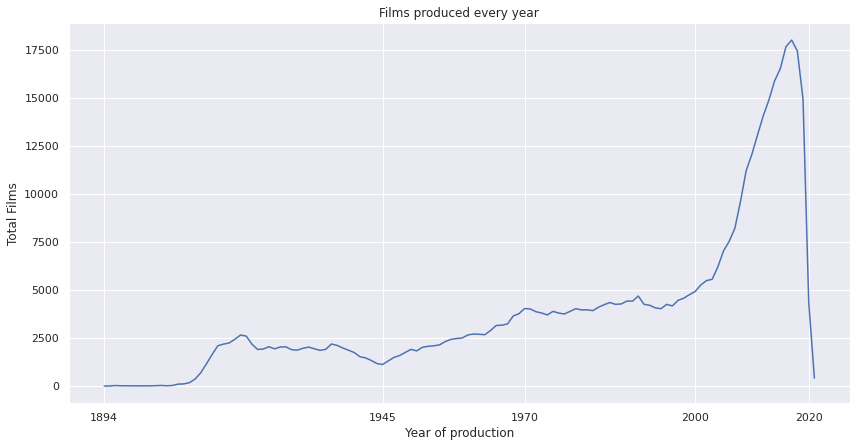

In [ ]:
import matplotlib
sns.set(rc={"figure.figsize":(14,7)})
ax = sns.lineplot(x = "year", y = "films", data = res2.toPandas())
ax.set(title = "Films produced every year", xlabel = "Year of production", ylabel = "Total Films")
ax.set(xticks=['1894','1945','1970','2000','2020']);
ax2 = ax.get_figure()
ax2.savefig("films_every_year.png")

### Actors born every year

In [ ]:
query3 = """SELECT COUNT(nconst) as actor,birthYear
           FROM name_basics_s 
           WHERE birthYear > 1900
           GROUP BY birthYear
           ORDER BY birthYear ASC
           
            """

res3 = spark.sql(query3)
res3.show(130)


+-----+---------+
|actor|birthYear|
+-----+---------+
| 2071|     1901|
| 1989|     1902|
| 2047|     1903|
| 2191|     1904|
| 2138|     1905|
| 2275|     1906|
| 2362|     1907|
| 2455|     1908|
| 2368|     1909|
| 2479|     1910|
| 2421|     1911|
| 2608|     1912|
| 2543|     1913|
| 2726|     1914|
| 2550|     1915|
| 2561|     1916|
| 2514|     1917|
| 2752|     1918|
| 2784|     1919|
| 3585|     1920|
| 3617|     1921|
| 3679|     1922|
| 3666|     1923|
| 3863|     1924|
| 3926|     1925|
| 4005|     1926|
| 4050|     1927|
| 4145|     1928|
| 4159|     1929|
| 4282|     1930|
| 4013|     1931|
| 3837|     1932|
| 3572|     1933|
| 3735|     1934|
| 3649|     1935|
| 3816|     1936|
| 3960|     1937|
| 4074|     1938|
| 4166|     1939|
| 4280|     1940|
| 4314|     1941|
| 4479|     1942|
| 4640|     1943|
| 4678|     1944|
| 4451|     1945|
| 4867|     1946|
| 5245|     1947|
| 4851|     1948|
| 4620|     1949|
| 4635|     1950|
| 4551|     1951|
| 4626|     1952|
| 4563|   

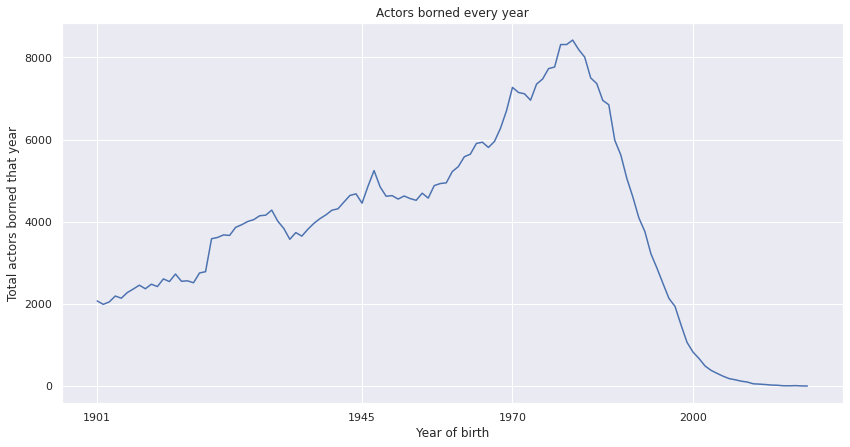

In [ ]:
import matplotlib
sns.set(rc={"figure.figsize":(14,7)})
ax3 = sns.lineplot(x = "birthYear", y = "actor", data = res3.toPandas())
ax3.set(title = "Actors borned every year", xlabel = "Year of birth", ylabel = "Total actors borned that year")
ax3.set(xticks=['1901','1945','1970','2000']);
ax4 = ax3.get_figure()
ax4.savefig("actors_every_year.png")

## MBA
We create a dataframe having only films and actors as columns

In [ ]:
from pyspark.sql.functions import collect_set

rawData = spark.sql("""SELECT p.primaryName, o.tconst
                       FROM name_basics_s p
                       INNER JOIN title_principals_s o 
                       INNER JOIN title_basics_s q 
                       where o.nconst = p.nconst 
                       and o.tconst = q.tconst 
                       and o.category = 'actor' 
                       and q.titleType = 'movie' """)
baskets = rawData.groupBy('tconst').agg(collect_set('primaryName').alias('actors'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5,truncate = False)

+---------+--------------------------------------------------------------------------------------------------+
|tconst   |actors                                                                                            |
+---------+--------------------------------------------------------------------------------------------------+
|tt0002591|[Harry Liedtke]                                                                                   |
|tt0003689|[William S. Rising, Octave Luzon, George W. Middleton, John Bowers, Wilbur Hudson]                |
|tt0004272|[Wilbur Higby, Francis Ford, Harry Schumm, Ernest Shields, Eddie Boland, Edgar Keller, Burton Law]|
|tt0004336|[Frank Farrington, Sidney Bracey, James Cruze]                                                    |
|tt0005209|[DeWolf Hopper Sr., Max Davidson, George Walsh]                                                   |
+---------+--------------------------------------------------------------------------------------------------+
o

In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol='actors', minSupport=0.00001, minConfidence=0.1)
model = fpGrowth.fit(baskets)

### Most popular Item

In [ ]:
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket = mostPopularItemInABasket.sort('freq', ascending = False)
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

mostPopularItemInABasket.show(10)

+------------------+----+
|             items|freq|
+------------------+----+
|    [Brahmanandam]| 798|
|     [Adoor Bhasi]| 585|
|[Matsunosuke Onoe]| 565|
|    [Eddie Garcia]| 507|
|      [Prem Nazir]| 438|
|    [Sung-il Shin]| 411|
|    [Paquito Diaz]| 391|
|[Masayoshi Nogami]| 387|
|       [Mammootty]| 381|
|         [Bahadur]| 348|
+------------------+----+
only showing top 10 rows



### Association Rules

In [ ]:
# Display generated association rules.
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show(10, truncate = False)

+----------------------------+----------------------+-------------------+------------------+---------------------+
|antecedent                  |consequent            |confidence         |lift              |support              |
+----------------------------+----------------------+-------------------+------------------+---------------------+
|[Lo Ban-Chiu, Hark-Suen Lau]|[Sau-Nin Wong]        |0.7777777777777778 |1787.2859078590786|1.8574438388587864E-5|
|[Lo Ban-Chiu, Hark-Suen Lau]|[Suet-Fei Leong]      |0.5555555555555556 |2829.2942942942946|1.3267455991848474E-5|
|[Lo Ban-Chiu, Hark-Suen Lau]|[Tsi-Hau Tsat]        |0.4444444444444444 |5775.662835249042 |1.061396479347878E-5 |
|[Gustav Botz, Henry Bender] |[Louis Brody]         |0.8                |17734.682352941178|1.061396479347878E-5 |
|[Gustav Botz, Henry Bender] |[Georg Alexander]     |0.8                |2200.6540145985405|1.061396479347878E-5 |
|[Kikuya Okada, Ryûsui Iwami]|[Tsumasaburô Bandô]   |1.0                |2617.09

### Predictions

In [ ]:
# transform examines the input items against all the association rules and summarize the consequents as prediction
associations = model.transform(baskets)
associations.show(10)

+---------+--------------------+--------------------+
|   tconst|              actors|          prediction|
+---------+--------------------+--------------------+
|tt0002591|     [Harry Liedtke]|                  []|
|tt0003689|[William S. Risin...|                  []|
|tt0004272|[Wilbur Higby, Fr...|[Roy Stewart, Phi...|
|tt0004336|[Frank Farrington...|  [Theodore Roberts]|
|tt0005209|[DeWolf Hopper Sr...|   [James A. Marcus]|
|tt0005605|[Arthur Bauer, No...|     [Harris Gordon]|
|tt0005793|  [Wingold Lawrence]|                  []|
|tt0006204|[George Periolat,...|[Harvey Clark, Al...|
|tt0006207|[Hal Forde, T. Ju...|     [Robert Walker]|
|tt0006441|[Martin Kinney, G...|                  []|
+---------+--------------------+--------------------+
only showing top 10 rows



###Associations having Keanu Reeves as Prediction

In [ ]:
from pyspark.sql.functions import array_contains
selected_actor = associations.filter(array_contains(associations.prediction,'Keanu Reeves'))

In [ ]:
selected_actor.show(10, truncate = False)

+----------+-------------------------------------------------------------------+----------------------------+
|tconst    |actors                                                             |prediction                  |
+----------+-------------------------------------------------------------------+----------------------------+
|tt0104073 |[René Assa, Jeff Goldblum, Laurence Fishburne]                     |[Keanu Reeves]              |
|tt6251004 |[Laurence Fishburne]                                               |[Keanu Reeves]              |
|tt3703908 |[Thomas Jane, Laurence Fishburne]                                  |[Keanu Reeves]              |
|tt0181739 |[David Hyde Pierce, Chris Rock, Laurence Fishburne]                |[Adam Sandler, Keanu Reeves]|
|tt1355644 |[Michael Sheen, Chris Pratt, Laurence Fishburne]                   |[Keanu Reeves]              |
|tt10239572|[Glenn Plummer, Thomas Jane, Drew Van Acker, Laurence Fishburne]   |[Keanu Reeves]              |
|tt0119081

### Most Frequent set of 2 items

In [ ]:
query = """select items, freq
           from mostPopularItemInABasket
           where size(items) > 1 and size(items) < 3
           order by freq desc
           limit 20"""
spark.sql(query).show(10, truncate = False)

+----------------------------------------+----+
|items                                   |freq|
+----------------------------------------+----+
|[Prem Nazir, Adoor Bhasi]               |237 |
|[Bahadur, Adoor Bhasi]                  |169 |
|[Kijaku Ôtani, Matsunosuke Onoe]        |147 |
|[Kitsuraku Arashi, Matsunosuke Onoe]    |126 |
|[Thikkurisi Sukumaran Nair, Adoor Bhasi]|122 |
|[Kitsuraku Arashi, Kijaku Ôtani]        |113 |
|[Suminojo Ichikawa, Matsunosuke Onoe]   |113 |
|[Panchito, Dolphy]                      |103 |
|[Thikkurisi Sukumaran Nair, Prem Nazir] |101 |
|[Suminojo Ichikawa, Kijaku Ôtani]       |101 |
|[Sen'nosuke Nakamura, Matsunosuke Onoe] |97  |
|[Suminojo Ichikawa, Kitsuraku Arashi]   |97  |
|[Bahadur, Prem Nazir]                   |96  |
|[Hôshô Bandô, Ritoku Arashi]            |96  |
|[Paravoor Bharathan, Adoor Bhasi]       |92  |
|[Enshô Jitsukawa, Ritoku Arashi]        |90  |
|[Madhu, Adoor Bhasi]                    |89  |
|[Sen'nosuke Nakamura, Kijaku Ôtani]    

### Best Association Rules

In [ ]:
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence, lift
           from associationRules
           order by confidence DESC
           limit 50"""

spark.sql(query).show(10)

+--------------------+------------------+----------+------------------+
|     antecedent (if)| consequent (then)|confidence|              lift|
+--------------------+------------------+----------+------------------+
|[Al Ritz, The Rit...|      [Jimmy Ritz]|       1.0|41873.555555555555|
|[Utae Nakamura, S...|    [Kijaku Ôtani]|       1.0|2340.7577639751553|
|[Mario Escudero, ...|     [Vic Varrion]|       1.0|13459.357142857143|
|[Shôkô Ichikawa, ...|[Kanzaburô Arashi]|       1.0| 6978.925925925925|
|[Mario Escudero, ...|    [Lito Anzures]|       1.0|3589.1619047619047|
|       [Óbis József]|    [Bolla Attila]|       1.0|37686.200000000004|
|[Mario Escudero, ...|    [Victor Bravo]|       1.0|3221.0427350427353|
|       [Óbis József]|     [Szabó Antal]|       1.0| 34260.18181818182|
|[Teinosuke Kinuga...| [Kaichi Yamamoto]|       1.0| 1728.724770642202|
|[Masashi Hirose, ...|    [Akira Kamiya]|       1.0| 13957.85185185185|
+--------------------+------------------+----------+------------